In [191]:
!pip install nnv

In [235]:
## data science essentials 
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image

## deep learning utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset

## notebook display
from IPython.display import clear_output
from tqdm.notebook import tqdm

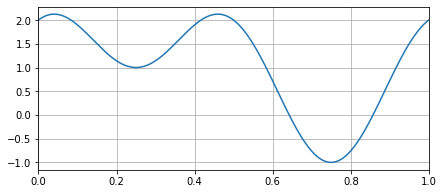

In [303]:
plt.rcParams['figure.figsize'] = 7, 3


sine = np.sin(np.linspace(0,2*np.pi, 1000, endpoint = True)) + 2*np.cos(np.linspace(0,2*np.pi, 1000, endpoint = True))**2
x_axis = [i/len(sine) for i in range(len(sine))]
plt.plot(x_axis,sine)
plt.xlim(0,1)
plt.grid()


In [304]:
x_s = torch.FloatTensor([i/len(sine) for i in range(len(sine))])
y_s = torch.FloatTensor(sine)

In [305]:
x_s.size()

torch.Size([1000])

In [306]:
y_s.size()

torch.Size([1000])

In [307]:
full_dataset = TensorDataset(x_s, y_s)    ## make compatible with DataLoader 
train_loader = DataLoader(dataset=full_dataset, batch_size=16, shuffle=True)

x,y = next(iter(train_loader))
print(x.size(),y.size())

torch.Size([16]) torch.Size([16])


In [308]:
class Model(nn.Module):
    def __init__(self, layer_sizes):
        
        super(Model, self).__init__()
        
        self.layer_sizes = layer_sizes
        self.layers = nn.ModuleList([nn.Linear(self.layer_sizes[i], self.layer_sizes[i+1]) for i in range(len(self.layer_sizes)-1)])            
        
    def forward(self, x):
        
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = self.layers[-1](x)
        
        return x 

def create_a_model(layer_sizes = [1, 8, 16,16, 1]):
    return Model(layer_sizes = layer_sizes)

In [309]:
def train_step(x, y, model, optimizer):
    x = x.unsqueeze(-1)
    y = y.unsqueeze(-1)
    
    optimizer.zero_grad()
    pred = model(x)
    loss = F.mse_loss(pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()



def train(model,epochs, optimizer, show_metrics = True ):
    losses = []
    model.train()
    for m in tqdm(range (epochs)):
        for x_batch, y_batch in train_loader:
                loss = train_step(x_batch, y_batch, model, optimizer)
                losses.append(loss)

    if show_metrics == True:
        plt.plot(losses)
        plt.grid()
        plt.show()

In [311]:
model = create_a_model(layer_sizes = [1,5,15,1])

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

model.apply(init_weights)

Model(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=15, bias=True)
    (2): Linear(in_features=15, out_features=1, bias=True)
  )
)

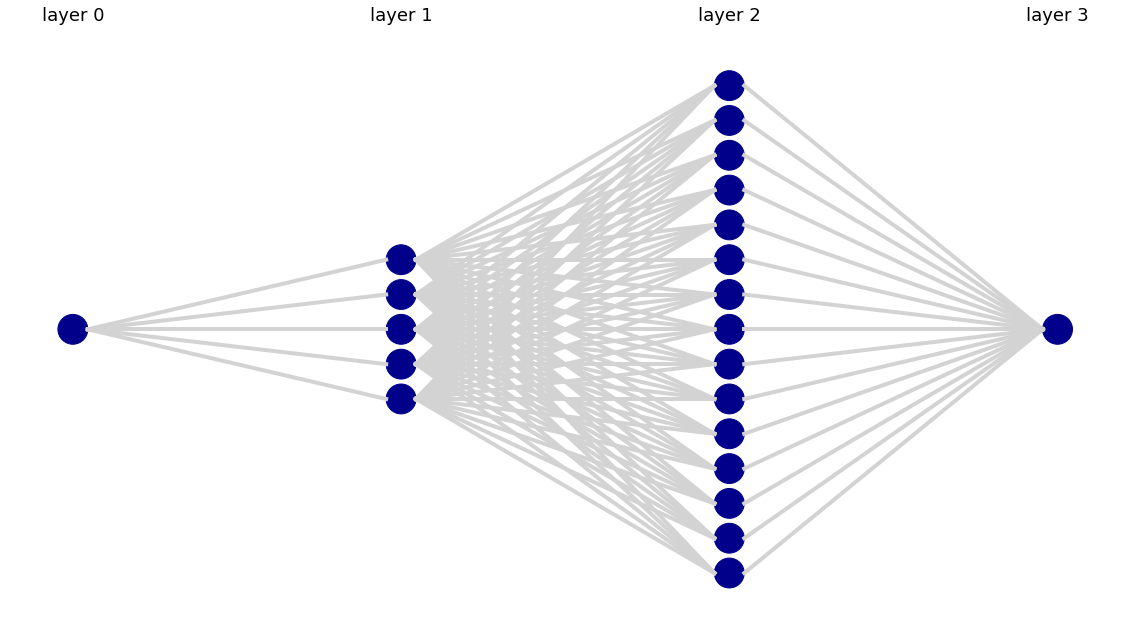

In [312]:
# def visualize_model(layer_sizes)
from nnv import NNV

layersList = [
    {"title":"layer " + str(i), "units": model.layer_sizes[i], "color": "darkBlue"} for i in range(len(model.layer_sizes))
]

plt.rcParams["figure.figsize"] = (20,20)

fig,ax = NNV(layersList,  max_num_nodes_visible= max(model.layer_sizes), node_radius=3).render()

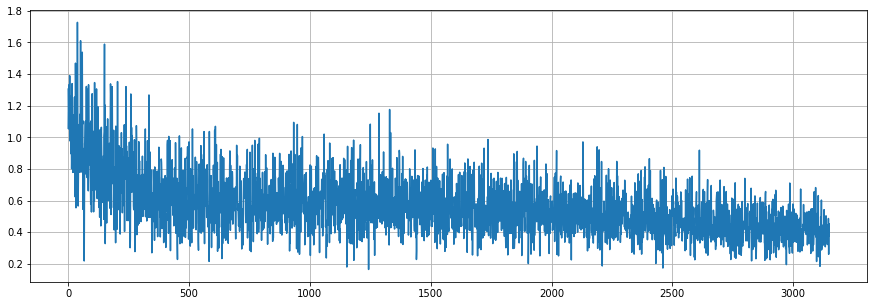

In [313]:
plt.rcParams["figure.figsize"] = (15,5)

optimizer = optim.Adam(model.parameters(), lr = 0.001) 
train(model, 50, optimizer, show_metrics = True)

In [314]:
preds = model(torch.tensor(x_axis).unsqueeze(-1).float()).view(-1).detach().numpy()

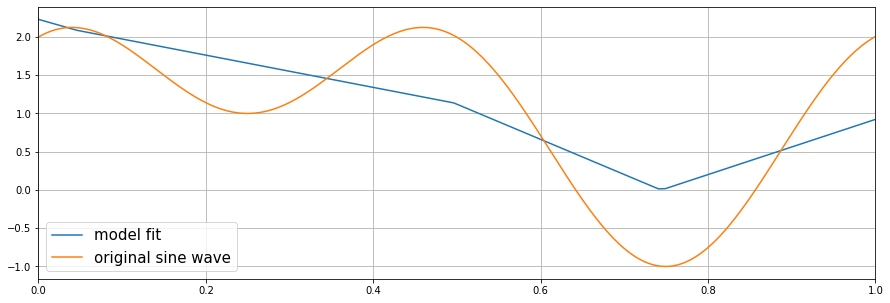

In [315]:
plt.plot(x_axis, preds, label = "model fit")
plt.plot(x_axis,sine, label = "original sine wave")
plt.xlim(0,1)
plt.legend(fontsize = 15)
plt.grid()

In [136]:
!mkdir animation

mkdir: cannot create directory ‘animation’: File exists


In [321]:
def train_and_compare_preds(architectures):
    count = 0
    for layer_sizes in architectures:
        # print(layer_sizes)

        model = create_a_model(layer_sizes = layer_sizes)
        model.apply(init_weights)

        layersList = [
            {"title":"layer " + str(i), "units": model.layer_sizes[i], "color": "darkBlue"} for i in range(len(model.layer_sizes))
        ]

        plt.rcParams["figure.figsize"] = (15,5)

        fig,ax = NNV(layersList,  max_num_nodes_visible= max(model.layer_sizes), spacing_layer= 150,node_radius=5).render(save_to_file="animation/nn_" + str(count) +".jpg")
        plt.close("all")

        optimizer = optim.Adam(model.parameters(), lr = 0.001) 
        train(model, 80, optimizer,  show_metrics = False)

        preds = model(torch.tensor(x_axis).unsqueeze(-1).float()).view(-1).detach().numpy()

        plt.rcParams["figure.figsize"] = (10,5)

        plt.plot(x_axis, preds, label = "model fit", linewidth = 2)
        plt.plot(x_axis,sine, label = "original curve", linewidth = 2)

        plt.xlabel("loss = " + str(round(np.mean(np.abs(preds-sine)),4)), fontsize = 18)

        plt.xlim(0,1)
        plt.legend(fontsize = 15)
        plt.grid()
        plt.savefig("animation/pred_" + str(count) +".jpg", bbox_inches='tight')
        plt.close()
        count += 1

In [ ]:
arch = [
        [1,10,1],
        [1,5,10,1],
        [1,5,5,10,1],
        [1,5,10,10,1],
        [1,10,10,10,1]
        
]
train_and_compare_preds(arch)


In [ ]:
# !mkdir animation_final

In [328]:
for i in range(len(arch)):
    nn_vis = cv2.resize(cv2.imread("animation/" + "nn_" + str(i) + ".jpg"), (1024, 250))
    pred = cv2.imread("animation/"+"pred_"+  str(i) + ".jpg")
    fig, ax = plt.subplots(1,2,figsize = (17,5) )

    ax.flat[0].imshow(nn_vis)
    ax.flat[0].axis("off")
    ax.flat[1].imshow(pred)
    ax.flat[1].axis("off")

    fig.savefig("animation_final/" + str(i)+ ".jpg")

    plt.close("all")


In [329]:
names = [ "animation_final/" + str(i) + ".jpg" for i in range (len(arch))]
images = []
for n in names:
    frame = Image.open(n)
    images.append(frame)
print(len(images))

5


In [330]:
images[0].save('nn_comparisons.gif',
               save_all=True,
               append_images=images[1:],
               duration=1000,
               loop=0)

You might've got a gif that looks like:

<img src = 'https://raw.githubusercontent.com/Mayukhdeb/gradient-games/master/images/layers_vs_non_linearity.gif'>